# Finetuning

![asstes/FolderStructure.jpg](assets/FolderStructure.jpg)


Due to the sort order 'Fire' comes before 'NoFire' so the class index is as follows:

- 0: Fire
- 1: NoFire

While I have created a custom kernel for this class to access the GPU - there is a standard kernel Intel provides (without the support libraries such as pandas, and seabron, etc) called **pytorch_xpu** that I would recommend for quick testing of a PyTorch model.

## Fintuning is awesome! 

![assets/fine_tuning.png](assets/fine_tuning.png)

Finetuning allows me to train a small number of iterations of a small number of images to create a custom model quickly.  It does this by freezing most of the layers of a pretrianed model such as resnet, and allowing me to train just the very last layers.

As a reuslt, this notebook can be run quite fast on our Intel(r) 4th generation Xeon(r) Scalable processors!  But it can allso be run even faster on out Intel(r) PVC GPU's

We will be deomonstraing how to train against the new Intel(r) GPUS in this exercise - taking advantage of c key ingredient supplied by the Intel(R) Extensions for PyTorch




In [1]:
# %load fine_tune.py
import os
import pathlib
import warnings
import random
import time
import gc
from typing import Tuple
#import glob
from PIL import Image
from os.path import exists
import os
warnings.filterwarnings("ignore")

import torch
import intel_extension_for_pytorch
import numpy as np
import matplotlib.pyplot as plt
import wandb
import seaborn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from batch_finder import optimum_batch_size
from config import set_seed, device
from data_loader import (
    TRAIN_DIR,
    VALID_DIR,
    augment_and_save,
    data_distribution,
    imagenet_stats,
    img_transforms,
    plot_data_distribution,
    show_data,
)
from metrics import Metrics
from model import FireFinder
from trainer import Trainer
from lr_finder import LearningRateFinder
from torch import optim



def create_dataloader(
    directory: str, batch_size: int, shuffle: bool = False, transform=None
) -> DataLoader:
    """
    Create a DataLoader from a directory of images.

    Args:
        directory (str): Directory containing images.
        batch_size (int): Batch size for the DataLoader.
        shuffle (bool, optional): Whether to shuffle the data. Defaults to False.
        transform ([type], optional): Transformations to apply to the images. Defaults to None.

    Returns:
        DataLoader: DataLoader with images from the directory.
    """
    data = datasets.ImageFolder(directory, transform=transform)
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle)


def setup_dataloaders(config: dict) -> Tuple[DataLoader, DataLoader]:
    """
    Setup train and validation DataLoaders.

    Args:
        config (dict): Configuration dictionary containing batch_size.

    Returns:
        Tuple[DataLoader, DataLoader]: A tuple containing train and validation dataloaders.
    """
    return create_dataloader(
        TRAIN_DIR, config["batch_size"], shuffle=True, transform=img_transforms["train"]
    ), create_dataloader(
        VALID_DIR, config["batch_size"], transform=img_transforms["valid"]
    )


def find_lr(model: FireFinder, optimizer: optim.Adam, dataloader: DataLoader) -> float:
    """
    Find best learning rate using Learning Rate Finder.

    Args:
        model (FireFinder): FireFinder model.
        optimizer (optim.Adam): Adam optimizer.
        dataloader (DataLoader): DataLoader with training data.

    Returns:
        float: Best learning rate.
    """
    lr_finder = LearningRateFinder(model, optimizer, device)
    best_lr = lr_finder.lr_range_test(dataloader, start_lr=1e-2, end_lr=1e-5)
    return best_lr


def train(model: FireFinder, trainer: Trainer, config: dict):
    """
    Train a FireFinder model.

    Args:
        model (FireFinder): FireFinder model.
        trainer (Trainer): Trainer to train the model.
        config (dict): Configuration dictionary containing learning rate and batch size.
    """
    train_dataloader, valid_dataloader = setup_dataloaders(config)
    print("training data")
    plot_data_distribution(data_distribution(train_dataloader.dataset, TRAIN_DIR))
    print("\nvalidation data")
    plot_data_distribution(data_distribution(valid_dataloader.dataset, VALID_DIR))
    print(f"______________")
    start = time.time()
    val_acc = trainer.fine_tune(train_dataloader, valid_dataloader)
    model_save_path = f"./models/model_acc_{val_acc}_device_{device}_lr_{trainer.lr}_epochs_{EPOCHS}.pt"
    torch.save(model.state_dict(), model_save_path)

    model.eval()
    with torch.no_grad():
        model_scripted = torch.jit.script(model)  # Export to TorchScript
        model_scripted.save(f"{model_save_path.replace('.pt','_jit.pt')}")  # Jit Save

    print(f"Model saved to :{model_save_path}")
    print(f"Time elapsed: {time.time() - start} seconds.")
    return (model_save_path)

2023-08-02 00:15:18,789 - numexpr.utils - INFO - Note: detected 224 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-08-02 00:15:18,790 - numexpr.utils - INFO - Note: NumExpr detected 224 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-08-02 00:15:18,790 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Device set to xpu by user.
OMP_NUM_THREADS set to: 112


Train folder data/shift/train
Validation folder data/shift/val
Using epoch: 5
Using Dropout: 0.3
Running in Finetuning mode.
Using batch size: 64
Using learning rate: 0.000214
Running in Finetuning mode.
training data


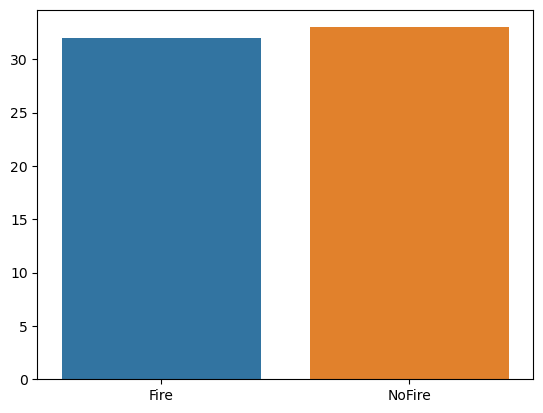


validation data


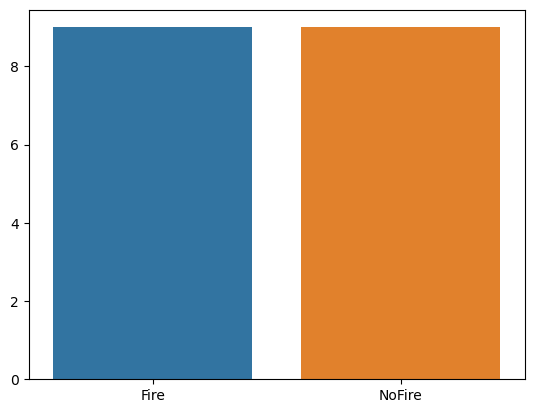

______________


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/u103128/.netrc


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]



📅 Epoch 1/5:
	🏋️‍♂️ Training step:
	 - 🎯 Loss: 0.8811, 📈 Accuracy: 0.4000
	🧪 Validation step:
	 - 🎯 Loss: 0.8118, 📈 Accuracy: 0.5556
⏱️ Time: 19.5041 sec



100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]



📅 Epoch 2/5:
	🏋️‍♂️ Training step:
	 - 🎯 Loss: 0.5396, 📈 Accuracy: 0.8462
	🧪 Validation step:
	 - 🎯 Loss: 0.7896, 📈 Accuracy: 0.5000
⏱️ Time: 3.0985 sec



100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]



📅 Epoch 3/5:
	🏋️‍♂️ Training step:
	 - 🎯 Loss: 0.5033, 📈 Accuracy: 0.8769
	🧪 Validation step:
	 - 🎯 Loss: 0.7652, 📈 Accuracy: 0.6111
⏱️ Time: 3.0685 sec



100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]



📅 Epoch 4/5:
	🏋️‍♂️ Training step:
	 - 🎯 Loss: 0.4627, 📈 Accuracy: 0.9077
	🧪 Validation step:
	 - 🎯 Loss: 0.6228, 📈 Accuracy: 0.6667
⏱️ Time: 3.0458 sec



100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


📅 Epoch 5/5:
	🏋️‍♂️ Training step:
	 - 🎯 Loss: 0.4127, 📈 Accuracy: 0.9692
	🧪 Validation step:
	 - 🎯 Loss: 0.4500, 📈 Accuracy: 0.7778
⏱️ Time: 3.0427 sec



Time,█▁▁▁▁
Train Acc,▁▆▇▇█
Train Loss,█▃▂▂▁
Training Acc,▁▁▆▆▇▇▇▇██
Training Loss,▄█▂▅▁▅▁▄▁▄
Valid Acc,▂▁▄▅█
Valid Loss,██▇▄▁
Validation Acc,▂▁▄▅█
Validation Loss,██▇▄▁
Time,3.04272
Train Acc,0.96923


Model saved to :./models/model_acc_77_device_xpu_lr_0.000214_epochs_5.pt
Time elapsed: 127.71655178070068 seconds.


In [2]:
# hyper params
EPOCHS = 5
DROPOUT = .3
# LR would be changed if we are using a LR finder
LR = 2.14e-4
#LR = 3.e-3
TEST_DIR = 'data/shift/'
BATCH_SIZE = 64 #128  # Default batch size

aug_data = False
find_batch = False
find_lr_rate = False
use_wandb = True
use_ipex=True

set_seed(42)
print(f"Train folder {TRAIN_DIR}")
print(f"Validation folder {VALID_DIR}")
print(f"Using epoch: {EPOCHS}")
print(f"Using Dropout: {DROPOUT}")

batch_size = BATCH_SIZE

if aug_data:
    print("Augmenting training and validation datasets...")
    t1 = time.time()
    augment_and_save(TRAIN_DIR)
    augment_and_save(VALID_DIR)
    print(f"Done Augmenting in {time.time() - t1} seconds...")

model = FireFinder(simple=True, dropout=DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=LR)
if find_batch:
    print(f"Finding optimum batch size...")
    batch_size = optimum_batch_size(model, input_size=(3, 224, 224))
print(f"Using batch size: {batch_size}")

best_lr = LR
if find_lr_rate:
    print("Finding best init lr...")
    train_dataloader = create_dataloader(
        TRAIN_DIR,
        batch_size=batch_size,
        shuffle=True,
        transform=img_transforms["train"],
    )
    best_lr = find_lr(model, optimizer, train_dataloader)
    del model, optimizer
    gc.collect()
    if device == torch.device("xpu"):
        torch.xpu.empty_cache()
print(f"Using learning rate: {best_lr}")

model = FireFinder(simple=True, dropout=DROPOUT)
trainer = Trainer(
    model=model,
    optimizer=optim.Adam,
    lr=best_lr,
    epochs=EPOCHS,
    device=device,
    use_wandb=use_wandb,
    use_ipex=use_ipex,
)
model_save_path = train(model, trainer, config={"lr": best_lr, "batch_size": batch_size})

In [3]:
def predict(InFldr, ScoreDict, model):
    import torchvision.transforms as transforms
    import torch.nn as nn
    import glob 
    model.eval()

    scores = []
    fns = []
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ])
    
    for fn in glob.glob(TEST_DIR+'*.png'):
        img = Image.open(fn)
        img_tensor = transform(img).reshape(1, 3, 1024, 1024)
        score = 0
        modelCPU = model.to("cpu")
        score = np.argmax(torch.softmax( modelCPU(img_tensor).detach(), dim =1).numpy().squeeze())
        fns.append(fn)
        scores.append(ScoreDict[score])
    return (scores, fns)
model.eval()
with torch.no_grad():
    model_scripted = torch.jit.script(model.to("cpu"))  # Export to TorchScript
    model_scripted.save(model_save_path)  # Jit Save

In [4]:
model_save_path
#resnet18_simpleFalse_IPEXTrue_Epochs12_dropout0.4_batch128
#model_name = f"resnet18_simple{simple}_IPEX{ipx}_Epochs{epochs}_dropout{dropout}_batch{batch_size}"
print(model_save_path)

model_read = torch.jit.load(model_save_path)
#model_read.eval()

./models/model_acc_77_device_xpu_lr_0.000214_epochs_5.pt


In [5]:
TEST_DIR =  'data/shift/val/Fire/'
scoreDict = {0:'Fire', 1:'NoFire'}
scores, fns = predict(TEST_DIR, scoreDict, model)
for score, fn in zip(scores, fns):
    print(f"{score}\t{fn}")

NoFire	data/shift/val/Fire/m_3912121_nw_10_h_20160713.png
Fire	data/shift/val/Fire/m_4012361_ne_10_h_20160712.png
NoFire	data/shift/val/Fire/m_3912122_nw_10_h_20160806.png
NoFire	data/shift/val/Fire/m_4012211_se_10_h_20160713.png
Fire	data/shift/val/Fire/m_3912250_sw_10_h_20160531.png
Fire	data/shift/val/Fire/m_3912252_ne_10_h_20160712.png
NoFire	data/shift/val/Fire/m_4012257_ne_10_h_20160712.png
Fire	data/shift/val/Fire/m_3912251_nw_10_h_20160531.png
NoFire	data/shift/val/Fire/m_3912324_ne_10_h_20160531.png


Notices and Disclaimers
Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure.

Your costs and results may vary.

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others.

In [6]:
TEST_DIR =  'data/shift/val/NoFire/'
scoreDict = {0:'Fire', 1:'NoFire'}
scores, fns = predict(TEST_DIR, scoreDict, model_read)
for score, fn in zip(scores, fns):
    print(f"{score}\t{fn}")

NoFire	data/shift/val/NoFire/m_3912149_nw_10_h_20160711.png
NoFire	data/shift/val/NoFire/m_4012162_se_10_h_20160806.png
NoFire	data/shift/val/NoFire/m_4012111_ne_10_h_20160808.png
NoFire	data/shift/val/NoFire/m_4012021_sw_10_h_20160719.png
NoFire	data/shift/val/NoFire/m_4012032_sw_10_h_20160719.png
NoFire	data/shift/val/NoFire/m_4012356_nw_10_h_20160713.png
NoFire	data/shift/val/NoFire/m_4012134_nw_10_h_20160717.png
NoFire	data/shift/val/NoFire/m_3912310_nw_10_h_20160528.png
NoFire	data/shift/val/NoFire/m_4012324_ne_10_h_20160811.png
